In [37]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from typing import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
import os, json, httpx
from dotenv import load_dotenv

load_dotenv()

class SoftwareRequestState(TypedDict):
    requester_id : str
    software_requested : str
    request_reason : str
    is_request_valid : bool
    requires_manager_approval : bool
    reason_rejection : str
    manager_decision : str
    llm_response : str

In [38]:
#NODES
whitelisted_softwares = [s.lower() for s in ["Visual Studio Code", "PyCharm", "IntelliJ IDEA", "GitHub Desktop", "Postman", "Docker Desktop", "7-Zip", "VLC Media Player", "Adobe Reader"]]
blacklisted_softwares = [s.lower() for s in ["uTorrent", "BitTorrent", "TeamViewer", "AnyDesk", "WhatsApp Desktop"]]
requires_manager_approval = [s.lower() for s in ["Jira", "Confluence", "Adobe Photoshop", "Adobe Illustrator", "Tableau", "Power BI", "SQL Server Management Studio", "VMware Workstation", "PostgreSQL"]]

llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    google_api_key = os.getenv("GOOGLE_API_KEY")
)

def employee_submit_request_node(state):
    user_message = interrupt(
        value = {
            "prompt" : "Describe your request in one message."
        }
    )

    prompt = f"""
    You will receive a user message requesting software license allocation.
    Extract the following fields exactly as stated by the user:

    - requester_id
    - software_requested
    - request_reason

    If the user did not provide a field, return an empty string for that field.
    Do not infer or assume anything.

    Return only a JSON dictionary with these three keys.

    User message:
    {user_message}
    """

    output = llm.invoke(prompt).content
    if output.startswith("```"):
        output = output.replace("```json","").replace("```","").strip()
    
    state["llm_response"] = output
    output = json.loads(output)

    requester_id = output.get("requester_id")
    software_requested = output.get("software_requested")
    request_reason = output.get("request_reason")

    if not requester_id:
        requester_id = interrupt(
            value = {
                "prompt": "You didn’t mentioned your Employee ID. Enter it now."
            }
        )
        # while not is_valid_requester_id(requester_id):
        #     requester_id = interrupt(
        #         value = {
        #             "prompt" : "Invalid Employee ID. Please try again."
        #         }
        #     )

    if not software_requested: 
        software_requested = interrupt( 
            value = { 
                "prompt" : "Which software do you need?" 
            } 
        ) 
    
    if not request_reason: 
        request_reason = interrupt( 
            value = { 
                "prompt" : "State the reason for requesting software." 
            } 
        )

    state["requester_id"] = requester_id.upper()
    state["software_requested"] = software_requested.lower()
    state["request_reason"] = request_reason.lower()

    return state

async def check_employee_id(requester_id):
    # prompt = f"""
    # You have to check whether an employee is part of our organization or not. 
    # The employee IDs will look like "PR1234", "PR2351", "WE5466", "CE4455".
    # The Employee IDs can be in lowercase so treat them similar.
    # Respond with only one word - "Valid" or "Invalid".

    # Employee ID to check is - {requester_id}
    # """

    # output = llm.invoke(prompt).content.strip().lower()
    # return output == "valid"
    async with httpx.AsyncClient() as client:
        res = await client.get(
            "http://localhost:8000/check-user",
            params = {
                "employee_id" : requester_id
            }
        )
        return res.json()
    
async def validate_request_node(state):
    requester_id = state["requester_id"]
    # if not is_valid_requester_id(requester_id):
    #     state["is_request_valid"] = False
    #     state["requires_manager_approval"] = False
    #     state["reason_rejection"] = "Invalid employee ID"
    #     return state
    data = await check_employee_id(requester_id)
    result = data["exists"]
    print(f"User Exists? - {result}")
    
    if result is False:
        state["is_request_valid"] = False
        state["requires_manager_approval"] = False
        state["reason_rejection"] = "Invalid employee ID"
        return state
    
    req = state["software_requested"].lower()
    if req in whitelisted_softwares:
        state["is_request_valid"] = True
        state["requires_manager_approval"] = False
    elif req in blacklisted_softwares:
        state["is_request_valid"] = False
        state["requires_manager_approval"] = False
        state["reason_rejection"] = "Software is blacklisted"
    elif req in requires_manager_approval:
        state["is_request_valid"] = True
        state["requires_manager_approval"] = True
    else:
        state["is_request_valid"] = True
        state["requires_manager_approval"] = True
    
    return state

def manager_approval_node(state):
    manager_response = interrupt(
        value = {
            "prompt" : "Manager Approval is required",
            "request_details" : {
                "employee_id" : state["requester_id"],
                "software_requested" : state["software_requested"],
                "request_reason" : state["request_reason"]
            },
            "options" : ["Approved", "denied"]
        }
    )

    if manager_response.lower().startswith("den"):
        reason = interrupt(
            value = {
                "prompt": "Please provide the reason for rejecting this request."
            }
        )
        state["manager_decision"] = "denied"
        state["reason_rejection"] = reason or "Not Provided."
        return state

    if manager_response.lower().startswith("appr"):
        state["manager_decision"] = "approved"
        print("Request approved by manager.")
        return state

    state["manager_decision"] = "denied"
    state["reason_rejection"] = "Unknown Manager Response"
    print("Unknown manager response - defaulting to request denied.")
    return state

def reject_request_node(state):
    if state["is_request_valid"] is False: # checking exists or not rather than true/false
        print("---------------------------------------------------------------------------------------")
        print("Request rejected during validation - ")
    elif state["manager_decision"] == "denied":
        print("---------------------------------------------------------------------------------------")
        print("Request rejected by manager - ")
    
    return state

def license_allocation_node(state):
    print("---------------------------------------------------------------------------")
    print("Software License allocated sucessfully!!!!")
    return state

def notify_user_node(state):
    if state["is_request_valid"] is False:
        reason = state["reason_rejection"]
        print(f"Your request was denied. Reason: {reason}")
        return state
    elif state["manager_decision"] != "approved" and state["requires_manager_approval"]:
        print(f"Your request was denied. Reason: {state["reason_rejection"]}")
    else:
        print("Software has been installed")

def logging_process_node(state):
    print("--------------------------- Final State After All Nodes ---------------------------")
    for key,value in state.items():
        print(f"{key} : {value}")
    
    return state

In [39]:
# CONDITIONAL EDGES
def route_after_validate_request(state):
    if state["is_request_valid"] and state["requires_manager_approval"]:
        return "manager_approval"
    elif state["is_request_valid"] and state["requires_manager_approval"] is False:
        return "license_allocation"
    elif state["is_request_valid"] is False: # Same issue here and (else statement missing)
        return "reject_request"
    else:
        return "reject_request"

def route_after_manager_approval(state):
    if state["manager_decision"] == "approved":
        return "license_allocation"
    else:
        return "reject_request"

In [40]:
#GRAPH CREATION
graph = StateGraph(SoftwareRequestState)

graph.add_node("employee_submit_request", employee_submit_request_node)
graph.add_node("validate_request", validate_request_node)
graph.add_node("manager_approval", manager_approval_node)
graph.add_node("reject_request", reject_request_node)
graph.add_node("license_allocation", license_allocation_node)
graph.add_node("notify_user", notify_user_node)
graph.add_node("logging_process", logging_process_node)

graph.add_edge(START, "employee_submit_request")
graph.add_edge("employee_submit_request", "validate_request")
graph.add_edge("reject_request", "notify_user")
graph.add_edge("license_allocation", "notify_user")
graph.add_edge("notify_user", "logging_process")


graph.add_conditional_edges(
    "validate_request",
    route_after_validate_request,
    {"reject_request": "reject_request", "manager_approval": "manager_approval", "license_allocation": "license_allocation"}
)

graph.add_conditional_edges(
    "manager_approval",
    route_after_manager_approval,
    {"reject_request": "reject_request", "license_allocation": "license_allocation"}
)


graph.add_edge("logging_process", END)

memory = MemorySaver()
app = graph.compile(checkpointer=memory)

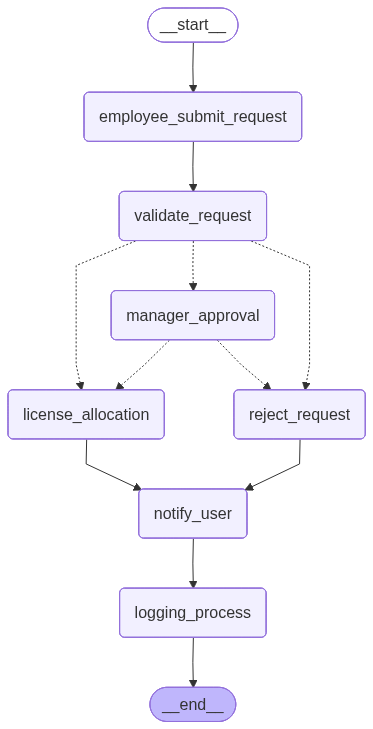

In [41]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
async def main():
    config = {"configurable": {"thread_id": "user-session-001"}}
    initial_state = {
        "requester_id": "",
        "software_requested": "",
        "request_reason": "",
        "is_request_valid": False,
        "requires_manager_approval": True,
        "reason_rejection": "",
        "manager_decision": "",
        "llm_response": {}
    }
    
    input_to_continue = None

    print("----------------------------- Initial State ------------------------------")
    for key,value in initial_state.items():
        print(f"{key} : {value}")

    while True:
        if input_to_continue is None:
            print("----------------------------- Workflow Starting -----------------------------")
            stream_input = initial_state
        else:
            print(f"Resuming with : {input_to_continue}")
            stream_input = Command(resume=input_to_continue)
        
        interrupted = False
        async for event in app.astream(stream_input, config, stream_mode="updates"):
            if "__interrupt__" in event:
                interrupted = True
                prompt_data = event["__interrupt__"][0].value

                print(f"Interrupt: {prompt_data.get('prompt')}")
                if "Manager" in prompt_data.get('prompt', ''):
                    print(f"Request Details : {prompt_data.get('request_details', [])}")
                    print(f"Options: {prompt_data.get('options', [])}")
                input_to_continue = input("Your input: ") or "Not Provided."
                break
        
        if not interrupted:
            print("----------------------------- Workflow completed -----------------------------")
            break

await main()

----------------------------- Initial State ------------------------------
requester_id : 
software_requested : 
request_reason : 
is_request_valid : False
requires_manager_approval : True
reason_rejection : 
manager_decision : 
llm_response : {}
----------------------------- Workflow Starting -----------------------------
Interrupt: Describe your request in one message.
Resuming with : Not Provided.
Interrupt: You didn’t mentioned your Employee ID. Enter it now.
Resuming with : we3729
Interrupt: Which software do you need?
Resuming with : vscode
Interrupt: State the reason for requesting software.
Resuming with : coding
User Exists? - True
Interrupt: Manager Approval is required
Request Details : {'employee_id': 'WE3729', 'software_requested': 'vscode', 'request_reason': 'coding'}
Options: ['Approved', 'denied']
Resuming with : deny
Interrupt: Please provide the reason for rejecting this request.
Resuming with : not needed
--------------------------------------------------------------